# Assignment

The municipality of Wageningen wants to know the volume of each building on the campus. Work with a project structure and create well-structured scripts with one main script. Divide the assignment into subtasks each in their commented section or if you want their own functions to derive the building volume of buildings on the campus:

    writeGeotiffToFile
    getGeotiffFromWebCoverageService
    getDataFromWebFeatureService
    calculateBuildingVolume
    visualizeBuildingVolume


In [1]:
#setup and import
from owslib.wcs import WebCoverageService
from owslib.wfs import WebFeatureService
wcs = WebCoverageService('http://geodata.nationaalgeoregister.nl/ahn2/wcs?service=WCS', version='1.0.0')
import pandas as pd
import geopandas as gpd
import rasterstats as rs
import json
import rasterio

#use this bounding box
x, y = 174100, 444100
bbox = (x-500, y-500, x+500, y+500)

In [106]:
### BEGIN SOLUTION

#get response for WCS
response = wcs.getCoverage(identifier='ahn2_05m_ruw', bbox=bbox, format='GEOTIFF_FLOAT32',
                           crs='urn:ogc:def:crs:EPSG::28992', resx=0.5, resy=0.5)
with open('./AHN2_05m_DSM.tif', 'wb') as file:
    file.write(response.read())

response = wcs.getCoverage(identifier='ahn2_05m_int', bbox=bbox, format='GEOTIFF_FLOAT32',
                           crs='urn:ogc:def:crs:EPSG::28992', resx=0.5, resy=0.5)
with open('./AHN2_05m_DTM.tif', 'wb') as file:
    file.write(response.read())

#open the responses with rasterio
DSM = rasterio.open("./AHN2_05m_DSM.tif", driver="GTiff")
DTM = rasterio.open("./AHN2_05m_DTM.tif", driver="GTiff")

#build canopy height model
CHM = DSM.read() - DTM.read()
kwargs = DSM.meta # Copy metadata of rasterio.io.DatasetReader
with rasterio.open('./AHN2_05m_CHM.tif', 'w', **kwargs) as file:
    file.write(CHM.astype(rasterio.float32))
CHMraster = rasterio.open("./AHN2_05m_CHM.tif", driver="GTiff")
    
# get feature data
bgtWfsUrl = 'https://geodata.nationaalgeoregister.nl/beta/bgt/wfs'
topographicalMapWFS = WebFeatureService(url=bgtWfsUrl, version='2.0.0')
responseBuildings = topographicalMapWFS.getfeature(typename='bgt:pand', bbox=bbox,
                                                   maxfeatures=100, outputFormat='json', startindex=0)
data = json.loads(responseBuildings.read())
buildingsGDF = gpd.GeoDataFrame.from_features(data['features'])

#compute zonal statistics
CHMbuildings = rs.zonal_stats(buildingsGDF, "./AHN2_05m_CHM.tif", prefix='CHM_', geojson_out=True)
buildingsGDF = gpd.GeoDataFrame.from_features(CHMbuildings)
# the new columns are added with a prefix 'CHM_'

#take list of areas, multiply with CHM mean
buildingsvolGS=(buildingsGDF['CHM_mean']*buildingsGDF.area)

#assign answer to what we found
answer=buildingsvolGS

### END SOLUTION
                            

In [83]:
#check correct type and length
assert(str(type(answer))==("<class 'pandas.core.series.Series'>"))
assert(len(answer)==100)

#check the first three answers, rounded to two decimal places
assert(round(answer[0],2)==105.56)
assert(round(answer[1],2)==822.05)
assert(round(answer[2],2)==18190.96)

In [101]:
### BEGIN HIDDEN TESTS

hidden_answer=[105.5646, 822.0501, 18190.9586, 19930.9969, 6302.9545, 102.3574, 86196.3121, 162.0734, 6861.1028, 290.8955, 86.4808, 413.5151, 405.1981, 9328.081, 1062.7275, 70.2164, 30004.6942, 6223.245, 11272.0856, 225.5664, 83032.6064, 264.7783, 2843.7507, 92501.0504, 2788.1277, 44.6575, 1043.3573, 130.3001, 9.0602, 8019.6783, 1395.6786, 2292.5671, 1117.4579,
 457.7597, 91017.3421, 83.8427, 88.0716, 4372.4047, 209.4318, 179.6909, 555.7334, 763.3422, 13827.6891, 187.3505, 262.0132, 89.5585, 446.0409, 133.7283, 28317.8558, 5210.9066, 715.0284, 104961.3289, 565.8702, 110.2694, 38.8829, 126.9731, 3959.8256, 108433.9738, 516.1186, 43465.8441, 523.3023, 1520.9853, 481.1524, 931.1574, 438.5649, 3036.5599,
 7506.3064, 231.465, 801.3033, 14814.292, 797.0358, 186369.0724, 780.3064, 681.1046, 15180.8154, 1952.4139, 3978.9956, 262.9755, 750.3664, 7282.1443, 2026.6253, 831.3056, 39473.2666, 63460.9746, 1584.9082, 274.2618, 830.3272, 196.815, 210.9075, 89.5381, 808.8324, 1117.0541, 1474.6658, 5294.3997, 4177.5985, 27605.9166, 95.2846, 312.8435, 149195.0652, 1239.4912]

for i,num in enumerate(hidden_answer):
    assert(round(answer[i],4)==num)

### END HIDDEN TESTS

### Plot a map of the campus buildings using data you used. 

create one of these maps (in order of decreasing difficulty):

* a map of buildings on campus, each building a single color representing volume, with a color scale on the side (full marks)

* raster map of Canopy Height Model with black outlines of buildings (partial marks)

* raster map of Canopy Height Model (fewer partial marks)

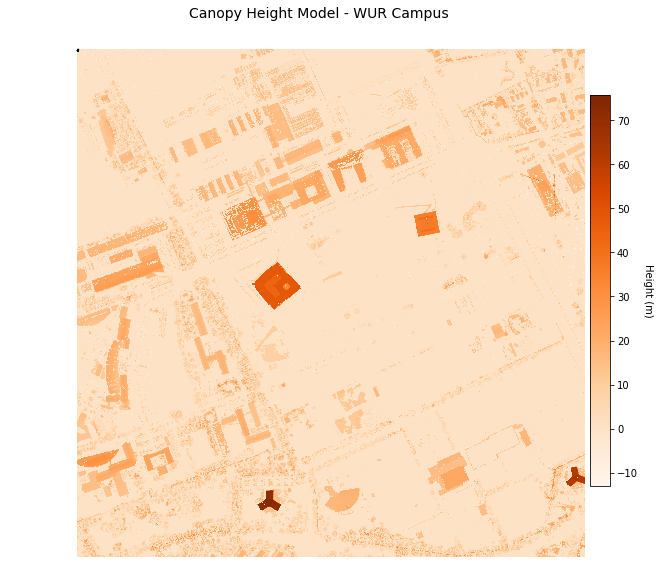

In [140]:
#plotting

### BEGIN SOLUTION

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
chmplot = ax.imshow(CHMraster.read(1), cmap='Oranges', extent=bbox)
ax.set_title("Canopy Height Model - WUR Campus", fontsize=14)
cbar = fig.colorbar(chmplot, fraction=0.035, pad=0.01)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Height (m)', rotation=270)
ax.set_axis_off()
buildingsGDF.plot(ax=ax,facecolor='none',edgecolor='black')
plt.show()

### END SOLUTION